In [1]:
# Loading dependencies.
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import linregress
import requests
import time
from api_key import ip_api_key
from api_key import ip_api_key2
from api_key import ip_api_key3
from api_key import ip_api_key4
from api_key import ip_api_key5
from datetime import datetime
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
import hvplot.pandas
from holoviews.util.transform import lon_lat_to_easting_northing




In [2]:
# Path to csv.
card_fraud_path_load = Path("resource/merged_file.csv")
card_data = pd.read_csv(card_fraud_path_load)

card_fraud_ernie_path_load = Path("resource/credit_card_fraud_flg_ernie.csv")
card_data_ernie = pd.read_csv(card_fraud_ernie_path_load)

card_fraud_thet_path_load = Path("resource/credit_card_fraud_flg_thet.csv")
card_data_thet = pd.read_csv(card_fraud_thet_path_load)

card_fraud_jimmy_path_load = Path("resource/credit_card_fraud_flg_jimmy.csv")
card_data_jimmy = pd.read_csv(card_fraud_jimmy_path_load)

card_fraud_mounika_path_load = Path("resource/credit_card_fraud_flg_mounika.csv")
card_data_mounika = pd.read_csv(card_fraud_mounika_path_load)

card_data.head()

,Transaction ID,IP,City,Lat,Lng,Continent,Capital,Country,Transaction Date and Time,Transaction Amount,...,Card Expiration Date,CVV Code (Hashed or Encrypted),Transaction Response Code,Fraud Flag or Label,Previous Transactions,Transaction Source,IP Address,Device Information,User Account Information,Transaction Notes
0,0003c9a2-3e18-499f-8b1f-f6f20eecb83c,11.133.155.94,Columbus,39.97883,-82.89573,North America,"Washington, D.C.","Washington, D.C.",2021-03-28 12:02:22,4584.73,...,09/31,162753c27c8b32975a0edf5e89ab4ed8e2f06f02a182e0...,0,1,3 or more,Online,11.133.155.94,Mobile,yuvraj-22,Culpa sit eligendi vel eaque aperiam quo. Sint...
1,001538cf-4b3c-4d81-9cce-fb74fa5c6427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-06-11 15:30:47,2895.00,...,01/25,1e68ed4e3d58a51096a7feea3947f40debf1fd9246ec97...,12,0,2,Online,102.205.87.49,Desktop,ukhanna,Assumenda amet corporis consectetur asperiores...
2,0016926c-d82a-4070-a0ad-cd1416674744,210.63.242.180,Taipei City,25.05437,121.60681,Asia,Taipei,Taipei,2023-07-16 01:16:14,1492.48,...,12/31,56f4da26ed956730309fa1488611ee0f13b0ac95ebb1bc...,5,1,2,In-Person,210.63.242.180,Tablet,NaN,Officiis incidunt minima magnam. Explicabo exp...
3,001b0dd8-5d3b-401a-9093-2093b562e559,175.92.199.54,Beijing,39.90499,116.40529,Asia,Beijing,Beijing,2021-12-08 15:57:04,1077.20,...,03/25,8b6cd7c429e83373dbd412f43d7422c0c4a127d93d0f2a...,12,1,3 or more,In-Person,175.92.199.54,Tablet,NaN,Qui quam ad ipsam ab atque ipsa. Qui tempore q...
4,003014ef-45b3-4743-bc6f-adab9a91a037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-07-12 03:15:14,2470.89,...,01/30,533eb9a8909f614c351b65e6b8aba1ffc2890735ce9a8a...,12,0,3 or more,Online,205.60.134.240,Desktop,wagletushar,Deserunt fugit impedit odio molestiae reiciend...


In [ ]:
def fetch_ip_data(df, api_key):
    # Base URL for the API
    base_url = f'https://api.ipgeolocation.io/ipgeo?'
    query_url_template = f"{base_url}apiKey={api_key}&ip="
    # Define an empty list to fetch the ipgeio data for each ip address
    ip_data = []
    # Print to logger
    print("Beginning Data Retrieval     ")
    print("-----------------------------")
    # Create counters
    record_count = 1
    set_count = 1
    # Loop through all the ip addresses to fetch ip geo location data
    for i, row in df.iterrows():
        ip_address = row['IP Address']
        transaction_id = row['Transaction ID']
        # Group cities in sets of 50 for logging purposes
        if (i % 50 == 0 and i >= 50):
            set_count += 1
            record_count = 0
        # Log the url, record, and set numbers
        print(f"Processing Record {record_count} of Set {set_count}|{ip_address}")
        # Add 1 to the record count
        record_count += 1
        # Run an API request for each of the ip addresses
        try:
            query_url = f"{query_url_template}{ip_address}"
            # Parse the JSON and retrieve data
            ip_geo = requests.get(query_url).json()
            # Parse out city, latitude, longitude, continent name, country capital and country name
            ip_city = ip_geo.get('city','N/A')
            ip_latitude = ip_geo.get('latitude','N/A')
            ip_longitude = ip_geo.get('longitude','N/A')
            ip_continent_name = ip_geo.get('continent_name','N/A')
            ip_country_capital = ip_geo.get('country_capital','N/A')
            ip_country_name = ip_geo.get('country_name','N/A')
            # Append the City information into city_data list
            ip_data.append({
                "Transaction ID": transaction_id,
                "IP": ip_address,
                "City": ip_city,
                "Lat": ip_latitude,
                "Lng": ip_longitude,
                "Continent": ip_continent_name,
                "Capital": ip_country_capital,
                "Country": ip_country_name
            })
        # If an error is experienced, skip the ip address
        except requests.RequestException as e:
            print("IP Address not found. Skipping...")
            continue
    #Convert the list of dictionaries to a DataFrame
    ip_data_df = pd.DataFrame(ip_data)
    # Indicate that Data Loading is complete
    print("-----------------------------")
    print("Data Retrieval Complete      ")
    print("-----------------------------")
    return ip_data_df

In [ ]:
ip_data_thet = fetch_ip_data(card_data_thet, ip_api_key2)

In [ ]:
ip_data_ernie = fetch_ip_data(card_data_ernie, ip_api_key)

In [ ]:
ip_data_jimmy = fetch_ip_data(card_data_jimmy, ip_api_key3)

In [ ]:
ip_data_mounika = fetch_ip_data(card_data_mounika, ip_api_key4)

In [ ]:
output_path = Path("resource/thet_ip_geolocation_data.csv")
ip_data_thet.to_csv(output_path, index = False)

output_path = Path("resource/ernie_ip_geolocation_data.csv")
ip_data_ernie.to_csv(output_path, index = False)

output_path = Path("resource/jimmy_ip_geolocation_data.csv")
ip_data_jimmy.to_csv(output_path, index = False)

output_path = Path("resource/mounika_ip_geolocation_data.csv")
ip_data_mounika.to_csv(output_path, index = False)


In [ ]:
# Combined the four csv files for IP Geolocation Data 
# Define file paths
file_paths = [
    Path("resource/ernie_ip_geolocation_data.csv"),
    Path("resource/jimmy_ip_geolocation_data.csv"),
    Path("resource/thet_ip_geolocation_data.csv"),
    Path("resource/mounika_ip_geolocation_data.csv")
]

# Load each CSV file into a separate DataFrame
dataframes = [pd.read_csv(file_path) for file_path in file_paths]

# Combine all DataFrames into a single DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)

# Optionally, save the combined DataFrame to a new CSV file
combined_df.to_csv("resource/combined_file.csv", index=False)

# Display the first few rows of the combined DataFrame
print(combined_df.head())

In [ ]:
# Merge the combined_df into the merged_file
# Load the credit card fraud data
credit_card_fraud_file_path = Path("resource/credit_card_fraud.csv")
credit_card_fraud_df = pd.read_csv(credit_card_fraud_file_path)

# Merge combined_df with credit_card_fraud_df on 'Transaction ID'
merged_df = pd.merge(combined_df, credit_card_fraud_df, on='Transaction ID', how='inner')

output_path = Path("resource/merged_file.csv")
merged_df.to_csv(output_path, index=False)

In [ ]:
card_data=card_data.copy()

In [ ]:
# General info on data.
card_data.info()

In [3]:
# Counted how many (potential) fraud or valid transactions there are in the data.
fraud_data = card_data[card_data['Fraud Flag or Label'] == 1]
fraud_data_count = len(fraud_data)
valid_data_row = card_data[card_data['Fraud Flag or Label'] == 0]
valid_data_count = len(valid_data_row)
print(f"There are {fraud_data_count} fraud or flag or labeled transactions in the dataset.")
print(f"There are {valid_data_count} valid transactions in the dataset.")

There are 3989 fraud or flag or labeled transactions in the dataset.
There are 4011 valid transactions in the dataset.


In [4]:
card_data['Cardholder Name'].value_counts()

Cardholder Name
Mamooty Chaudhuri      3
Eva Balasubramanian    3
Tiya Dugar             3
Trisha Ghose           3
Zara Rajagopalan       3
                      ..
Aaina Hayre            1
Aarush Dar             1
Himmat Hayer           1
Hunar Chaudhuri        1
Shaan Borah            1
Name: count, Length: 7651, dtype: int64

In [5]:
# Cardholder names that has fraud or flag or labeled transactions. (more than 1 means multiple transactions.)
fraudulent_cardholder = fraud_data.groupby(['Cardholder Name']).size()
fraudulent_cardholder.sort_values(ascending=False)

Cardholder Name
Tiya Dugar       3
Arhaan Kata      2
Gatik Sethi      2
Dhanuk Sekhon    2
Dhanuk Doshi     2
                ..
Hiran Talwar     1
Hiran Tandon     1
Hridaan Bains    1
Hridaan Brar     1
Zoya Yadav       1
Length: 3900, dtype: int64

In [6]:
# Checking to see if there is any null value in the column.
card_data['Transaction Date and Time'].isnull().sum()

0

In [7]:
# Formatted the column into a date form.
card_data_transaction_date = pd.to_datetime(card_data['Transaction Date and Time'], format ='%Y-%m-%d %H:%M:%S')
card_data_expiration_date = pd.to_datetime(card_data['Card Expiration Date'], format='%m/%y')
card_data["Merchant Category Code (MCC)"]=card_data["Merchant Category Code (MCC)"].astype(int)
card_data_transaction_date.head()

0   2021-03-28 12:02:22
1   2022-06-11 15:30:47
2   2023-07-16 01:16:14
3   2021-12-08 15:57:04
4   2023-07-12 03:15:14
Name: Transaction Date and Time, dtype: datetime64[ns]

In [8]:
# Create a copy of the fraudulent transactions data
flagged_data = card_data[card_data['Fraud Flag or Label'] == 1].copy()

# Convert the 'Transaction Date and Time' column to datetime
flagged_data['Transaction Date and Time'] = pd.to_datetime(fraud_data['Transaction Date and Time'], format ='%Y-%m-%d %H:%M:%S')

# Extract the month and hour from the transaction date
flagged_data['Month'] = flagged_data['Transaction Date and Time'].dt.month
flagged_data['Hour'] = flagged_data['Transaction Date and Time'].dt.hour

# Group by month & hour and count the number of transactions
flagged_transactions_per_month = flagged_data.groupby('Month').size()
flagged_transactions_per_hour = flagged_data.groupby('Hour').size()


In [9]:
# Sample group by with Month and transaction ID
flagged_transactions_per_month_id = flagged_data.groupby(['Month', 'Transaction ID']).size()
flagged_transactions_per_month_id



Month  Transaction ID                      
1      006692b3-4197-4362-a3f1-bbfc9102dcb7    1
       012b028f-7b2a-4cc5-b70c-7a3c9864f7a7    1
       02252f15-53a1-41fd-b408-38c60a441754    1
       03847613-9687-4df3-a012-c914408d8412    1
       04ba5701-94fd-46c6-8497-aca2737dbda5    1
                                              ..
12     fd0bbaa5-c7ef-48ea-b1c9-b3a381b2d352    1
       fd6dda26-9338-4941-9641-8a3cb5e36970    1
       fe33e0e3-2869-4031-a209-07c3027fb799    1
       fe8a2b5f-94b0-4eb2-97d9-11e158d867f8    1
       ffff5b51-80e6-47d7-85c1-06a23aeec816    1
Length: 3989, dtype: int64

In [10]:
# Seperated all the date data into 'year', 'month', 'day'.
card_data_transaction_year = card_data_transaction_date.dt.year
card_data_transaction_month = card_data_transaction_date.dt.month
card_data_transaction_day = card_data_transaction_date.dt.day

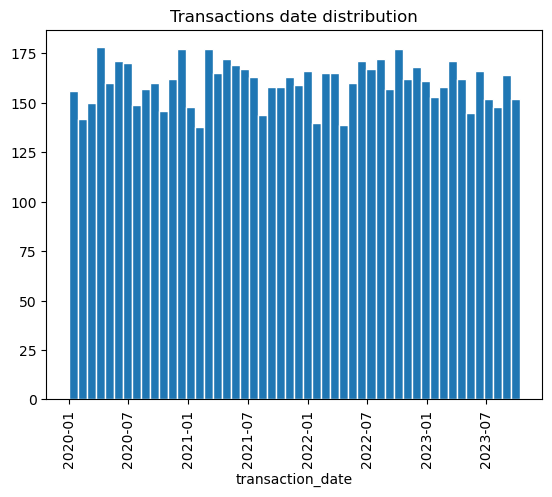

In [11]:
# Histogram for transaction date distribution.
plt.hist(card_data_transaction_date, bins=50, edgecolor='white')
plt.title("Transactions date distribution")
plt.xlabel("transaction_date")
plt.xticks(rotation=90, ha='center')
plt.show()

In [12]:
# Created new columns regarding year.
transactions_per_year = card_data.groupby(card_data_transaction_year).size()
transactions_per_year = transactions_per_year.reset_index()
transactions_per_year.columns = ['Year', 'Transaction per year']
transactions_per_year


,Year,Transaction per year
0,2020,2114
1,2021,2137
2,2022,2134
3,2023,1615


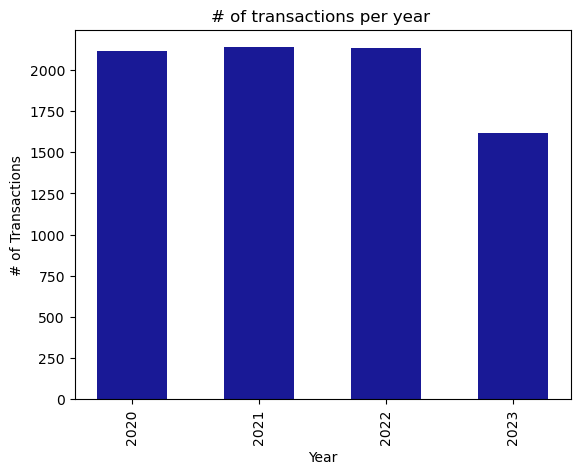

In [13]:
# Created bar graph to show transactions per year.
x_axis = transactions_per_year['Year']
y_axis = transactions_per_year['Transaction per year']

tick_locations = []

for x in x_axis:
    tick_locations.append(x)

plt.bar(x_axis, y_axis, color="darkblue", alpha=0.9, align="center", width=0.55)
plt.xticks(tick_locations, rotation=90, ha='center')
plt.title("# of transactions per year ")
plt.xlabel("Year")
plt.ylabel("# of Transactions")
plt.savefig('output/Fig1.png')
plt.show()


##### A noticeable decline in credit card transactions is evident in the year 2023. This trend could be attributed to a multitude of factors, but due to the constraints of our dataset, we can only hypothesize about the potential causes. One plausible explanation could be economic shifts that have led consumers to curtail their spending, thereby reducing the volume of credit card transactions. Alternatively, changes in consumer behavior might also be a contributing factor, with a possible shift towards alternative payment methods such as digital wallets or cryptocurrencies. Lastly, the aftermath of the COVID-19 pandemic could have influenced this trend. During the height of the pandemic, consumers may have been more inclined to utilize credit cards for transactions. However, as the situation normalized in 2023, a resurgence in in-person cash transactions could have occurred. These hypotheses, while informed, are speculative and further investigation would be beneficial to confirm these assumptions.

In [14]:
# Created new columns regarding month.
transactions_per_month = card_data.groupby(card_data_transaction_month).size()
transactions_per_month = transactions_per_month.reset_index()
transactions_per_month.columns = ['Month', 'Transactions per month']
transactions_per_month

,Month,Transactions per month
0,1,672
1,2,634
2,3,747
3,4,670
4,5,743
5,6,721
6,7,710
7,8,710
8,9,721
9,10,569


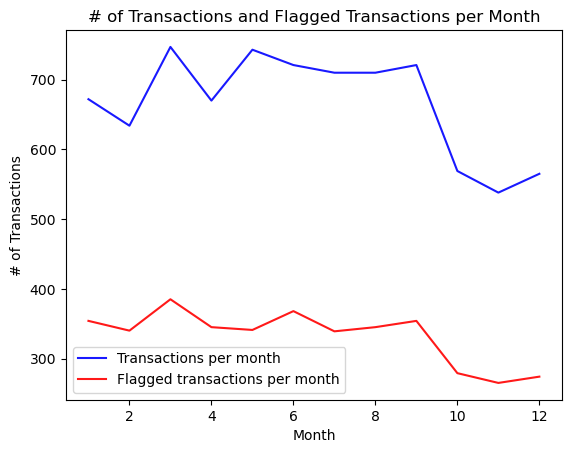

In [15]:
# Transactions per month
x_axis = transactions_per_month['Month']
y_axis = transactions_per_month['Transactions per month']
plt.plot(x_axis, y_axis, color="blue", alpha=0.9, label='Transactions per month')

# Flagged transactions per month
x_axis = flagged_transactions_per_month.index
y_axis = flagged_transactions_per_month.values
plt.plot(x_axis, y_axis, color="red", alpha=0.9, label='Flagged transactions per month')

plt.title("# of Transactions and Flagged Transactions per Month")
plt.xlabel("Month")
plt.ylabel("# of Transactions")
plt.legend()
plt.savefig('output/Fig2.png')
plt.show()


##### Upon further examination of the annual transaction graph, we embarked on a detailed analysis of monthly transaction patterns. Interestingly, we noted a significant contraction in user transactions commencing in September and extending through year-end. Regrettably, our dataset’s inherent limitations prevents us from identifying correlations or pinpointing definitive causes for this downturn. A more comprehensive investigation would be advantageous to deepen our understanding of this trend. Notably, the line graph of flagged transactions per month mirrors the overall transaction trend closely.

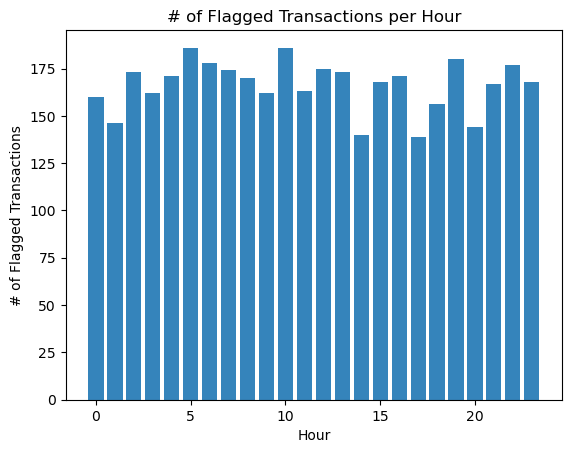

In [16]:
# Created bar graph
x_axis = flagged_transactions_per_hour.index
y_axis = flagged_transactions_per_hour.values

plt.bar(x_axis, y_axis, alpha=0.9)
plt.title("# of Flagged Transactions per Hour")
plt.xlabel("Hour")
plt.ylabel("# of Flagged Transactions")
plt.savefig('output/Fig3.png')
plt.show()



##### Upon analysis of the bar graph, it is evident that transaction flags peak at 5:00am, 10:00am, and 7:00pm. Consequently, it would be prudent for the credit card company to strategically allocate customer support resources during these high-activity periods to efficiently address customer needs.

In [1]:
# Aggregate the data to get the total count of fraudulent transactions per month
fraud_transactions_per_month_id_0 = flagged_transactions_per_month_id.groupby(level=0).count()

x_axis = fraud_transactions_per_month_id_0.index
y_axis = fraud_transactions_per_month_id_0.values

# Perform linear regression
(slope, intercept, r_value, p_value, std_err) = linregress(x_axis, y_axis)

# Create equation of line to calculate predicted fraudulent transaction
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Generate a scatter plot of fraudulent transactions over months
plt.scatter(x_axis, y_axis, alpha=0.9)
plt.title("# of Flagged Transactions per Month")
plt.xlabel("Month")
plt.ylabel("# of Flagged Transactions")

# Plot the regression line
plt.plot(x_axis, intercept + slope*x_axis, 'r', label='fitted line')

# Annotate the plot with the linear equation
plt.annotate(line_eq, xy=(0.15, 0.35), xycoords='axes fraction', fontsize=15, color="red")

print(f"The r_value is: {r_value}")
plt.savefig('output/Fig4.png')
plt.show()



NameError: name 'flagged_transactions_per_month_id' is not defined

##### The r-value of -0.74 suggest that there is a strong negative correlation between the month (x-axis) and the number of flagged transactions (y-axis). This means that as time progresses, the number of flagged transactions tends to decrease. For each month that passes, the model predicts approximately 7.93 fewer flagged transactions. However, this is a simple model and doesn’t prove causation, so other factors could also be influencing the decrease in flagged transactions.

In [17]:
# Exchange rates to USD (example rates, replace with actual rates)
exchange_rates = {
    "USD": 1.0,    # USD to USD
    "EUR": 1.2,    # 1 EUR = 1.2 USD
    "INR": 0.013   # 1 INR = 0.013 USD
}

# Function to convert amounts to USD
def convert_to_usd(amount, currency):
    return amount * round(exchange_rates[currency],2)

# Apply conversion to the dataframe
flagged_data["Amount in USD"] = flagged_data.apply(lambda row: convert_to_usd(row["Transaction Amount"], row["Transaction Currency"]), axis=1)

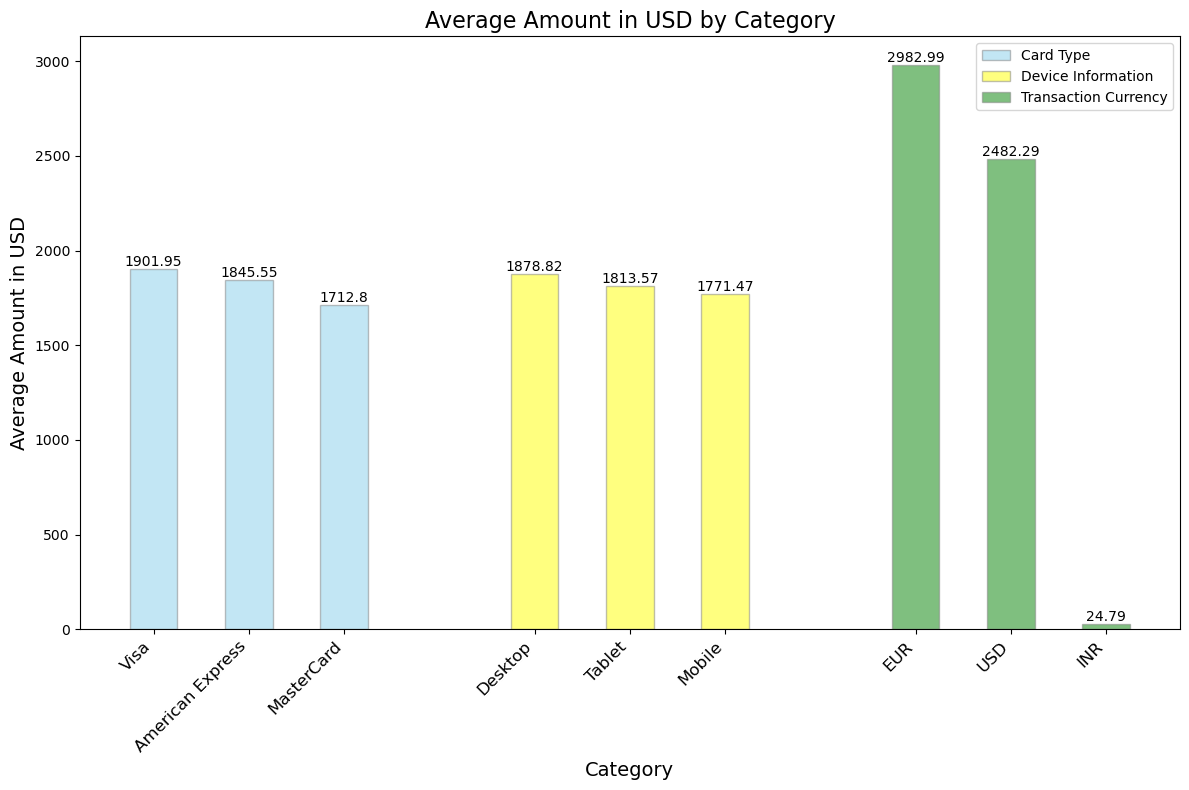

In [18]:
# Calculate the average transaction amount for each category and sort as per the provided parameters
card_type_avg = flagged_data.groupby("Card Type")["Amount in USD"].mean().sort_values(ascending=False).reset_index()
device_type_avg = flagged_data.groupby("Device Information")["Amount in USD"].mean().sort_values(ascending=False).reset_index()
currency_type_avg = flagged_data.groupby("Transaction Currency")["Amount in USD"].mean().sort_values(ascending=False).reset_index()

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Bar width
bar_width = 0.5

# Set bar positions for each category with a small gap between categories
gap = 1
r1 = np.arange(len(card_type_avg))
r2 = np.arange(len(device_type_avg)) + len(card_type_avg) + gap
r3 = np.arange(len(currency_type_avg)) + len(card_type_avg) + len(device_type_avg) + 2 * gap

# Plot bars
bars1 = plt.bar(r1, card_type_avg["Amount in USD"], color="skyblue", width=bar_width, edgecolor="grey", label="Card Type", alpha=0.5)
bars2 = plt.bar(r2, device_type_avg["Amount in USD"], color="yellow", width=bar_width, edgecolor="grey", label="Device Information", alpha=0.5)
bars3 = plt.bar(r3, currency_type_avg["Amount in USD"], color="green", width=bar_width, edgecolor="grey", label="Transaction Currency", alpha=0.5)

# Add labels for x-axis
all_positions = list(r1) + list(r2) + list(r3)
all_labels = list(card_type_avg["Card Type"]) + list(device_type_avg["Device Information"]) + list(currency_type_avg["Transaction Currency"])

plt.xlabel("Category", fontsize=14)
plt.xticks(all_positions, all_labels, rotation=45, ha='right', fontsize=12)

# Adding titles and labels
plt.title("Average Amount in USD by Category", fontsize=16)
plt.ylabel("Average Amount in USD", fontsize=14)

# Adding a legend
plt.legend()

# Adding text labels inside the bars
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

for bar in bars3:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()

# Show the plot
plt.savefig('output/Fig5.png')
plt.show()



##### The bar chart shows average transxn amount in USD by categories (Card Type, Device Information, and Transaction Currency)

##### Card Type: Visa has the highest average transaction amount, followed closely by American Express and MasterCard.This indicates that flagged transactions using Visa cards tend to be of higher value on average.

##### Device Information: Transactions made from desktops have the highest average amount, followed by tablets and mobiles.

##### Transaction Currency: Transactions in EUR have the highest average amount, followed by USD. The significantly lower average for INR indicates that flagged transactions in this currency are typically of much lower value.

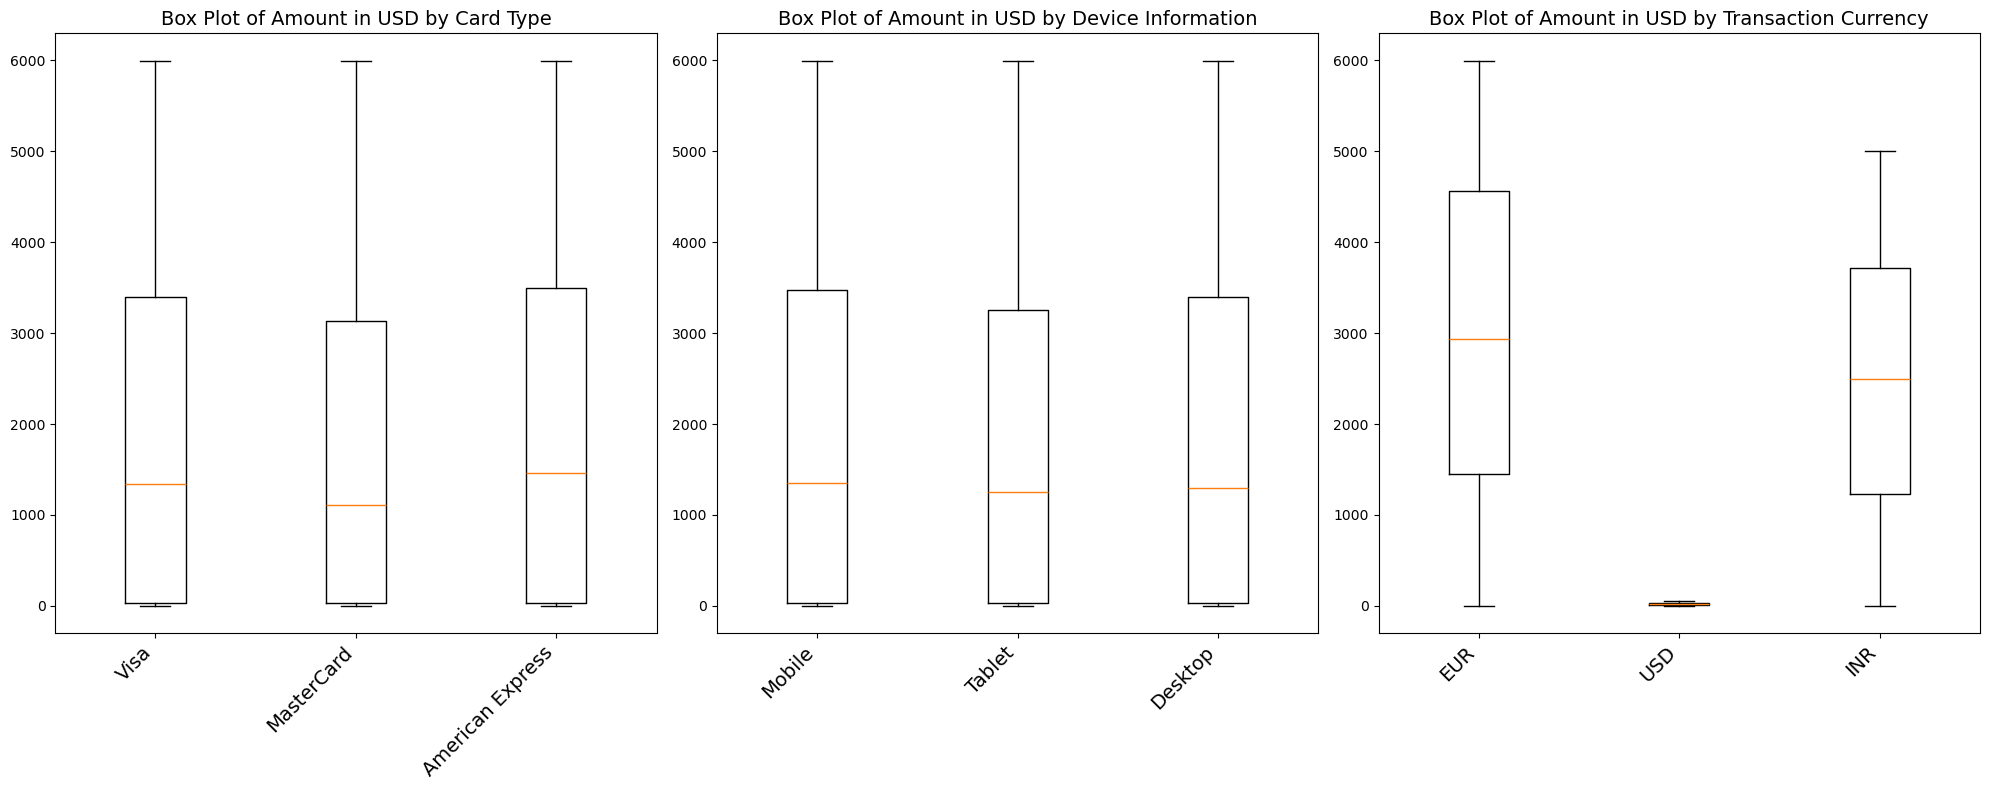

In [19]:
#Creating subplots for 3 categories vs transxn amount
# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Box Plot for Card Type
axes[0].boxplot([group["Amount in USD"].values for name, group in flagged_data.groupby('Card Type')])
axes[0].set_title('Box Plot of Amount in USD by Card Type',fontsize=14)
axes[0].set_xticklabels(flagged_data['Card Type'].unique(), rotation=45, ha='right',fontsize=14)

# Box Plot for Device Information
axes[1].boxplot([group["Amount in USD"].values for name, group in flagged_data.groupby('Device Information')])
axes[1].set_title('Box Plot of Amount in USD by Device Information',fontsize=14)
axes[1].set_xticklabels(flagged_data['Device Information'].unique(), rotation=45, ha='right',fontsize=14)

# Box Plot for Transaction Currency
axes[2].boxplot([group["Amount in USD"].values for name, group in flagged_data.groupby('Transaction Currency')])
axes[2].set_title('Box Plot of Amount in USD by Transaction Currency',fontsize=14)
axes[2].set_xticklabels(flagged_data['Transaction Currency'].unique(), rotation=45, ha='right',fontsize=14)

plt.tight_layout()
plt.show()

Box Plot Analysis
Card Type:
The median transaction amounts are relatively similar across Visa, MasterCard, and American Express.
The interquartile ranges (IQRs) are also comparable, indicating a similar spread of transaction values for these card types.

Insight: There is no significant outlier behavior in terms of transaction amounts among different card types, although Visa shows a slightly higher median.

Device Information:
All device categories (Mobile, Tablet, Desktop) show a similar distribution with a median around the $2,000 mark.
The IQRs are broad, indicating a wide range of transaction values.

Insight: Device type does not significantly affect the distribution of transaction amounts, though desktops slightly trend higher.

Transaction Currency:
EUR: Shows a wide distribution with a higher median and more extended upper whisker, indicating higher transaction values and more variability.
USD: Shows a tight distribution with a much lower median compared to the bar chart average, which suggests that the box plot median does not align with the average. This discrepancy could be due to the presence of high-value outliers affecting the average.
INR: Shows a lower median and a wide IQR with some high-value outliers.

Insight: The USD box plot median being low compared to the average indicates that while there are a few high-value transactions (outliers), most transactions are of low value. In contrast, EUR transactions are generally higher in value, consistent with the average.

In [20]:
# Perform ANOVA using statsmodels
# Combine all categorical columns into a long format for ANOVA
df_long = pd.melt(flagged_data, id_vars=['Amount in USD'], value_vars=['Card Type', 'Device Information', 'Transaction Currency'],
                  var_name='Category', value_name='Type')

# Perform ANOVA using statsmodels
model = ols('Q("Amount in USD") ~ C(Type)', data=df_long).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Perform ANOVA using scipy.stats (for each category separately)
card_type_anova = f_oneway(*[group["Amount in USD"].values for name, group in flagged_data.groupby('Card Type')])
device_type_anova = f_oneway(*[group["Amount in USD"].values for name, group in flagged_data.groupby('Device Information')])
currency_type_anova = f_oneway(*[group["Amount in USD"].values for name, group in flagged_data.groupby('Transaction Currency')])

print("ANOVA results for Card Type:", card_type_anova)
print("ANOVA results for Device Information:", device_type_anova)
print("ANOVA results for Transaction Currency:", currency_type_anova)

                sum_sq       df           F  PR(>F)
C(Type)   6.735368e+09      8.0  296.235843     0.0
Residual  3.398539e+10  11958.0         NaN     NaN
ANOVA results for Card Type: F_onewayResult(statistic=3.6837999050157655, pvalue=0.02521289817212182)
ANOVA results for Device Information: F_onewayResult(statistic=1.1523363263123125, pvalue=0.31600307989524856)
ANOVA results for Transaction Currency: F_onewayResult(statistic=1944.0899078049017, pvalue=0.0)


ANOVA Results Interpretation:
Card Type:


p-value: 0.025

Interpretation:
The p-value (0.025) is less than the typical significance level of 0.05, indicating that there are statistically significant differences in the average transaction amounts across different Card Types.

Device Information:
p-value: 0.316

Interpretation:
The p-value (0.316) is greater than 0.05, indicating that there is no statistically significant difference in the average transaction amounts across different Device Information categories.

Transaction Currency:
p-value: 0.0

Interpretation:
The p-value (0.0) is much less than 0.05, indicating a highly significant difference in the average transaction amounts across different Transaction Currencies.

Conclusion:
Card Type: There are significant differences in average transaction         amounts between different card types.

Device Information: There are no significant differences in average transaction amounts between different device types.

Transaction Currency: There are highly significant differences in average transaction amounts between different currencies.

In [ ]:
source_counts = flagged_data["Transaction Source"].value_counts()
source_counts

Interpretation:

The data shows a nearly even split between In-Person and Online transactions.
In-Person transactions are slightly higher by a margin of 59 transactions.

In [ ]:
#Accessing Merchant Category Codes and thier occurences
mcc_counts =flagged_data["Merchant Category Code (MCC)"].value_counts()
mcc_counts=mcc_counts.reset_index()
mcc_counts.columns=["Mcc","Counts"]
filtered_mcc=mcc_counts.loc[mcc_counts["Counts"]==4]

#Providing description to the MCC
bins = [0, 1500, 3000, 3300, 3500, 4000, 4800, 5000, 5700, 7300, 8000, 9000, 10000]
descriptions = [
    "Agricultural services",
    "Contracted services",
    "Airlines",
    "Car rentals",
    "Lodging",
    "Transportation services",
    "Utility services",
    "Retail outlet services",
    "Miscellaneous stores",
    "Business services",
    "Professional services and membership organizations",
    "Government services"
]
#Adding Description column to MCC
final_mcc = filtered_mcc.copy()
final_mcc.loc[:, "Description"] = pd.cut(filtered_mcc["Mcc"], bins, labels=descriptions, include_lowest=True)
final_mcc

#Filtering MCC codes with max occurence of 4
grouped_df = final_mcc.groupby('Description',observed=True)["Counts"].sum().reset_index()
filtered_df = grouped_df[grouped_df['Counts'] >= 4]

#Sorting MCC by their number of occurences
filtered_df = filtered_df.reset_index(drop=True).sort_values(by='Counts', ascending=False)
print(filtered_df.to_string(index=False))

#### This portion of the analysis contains observing Capital and the average transaction amounts where fraudulent flag equals 1.

In [ ]:
# Count unique number of capital in the database
flagged_data['Capital'].nunique()

In [ ]:
# Remove duplicate rows based on Country
card_data_dedup = flagged_data.drop_duplicates(subset=['Capital'])

# Check that the filtered data frame is the same size as the number of unique countries
card_data_dedup.count()

In [ ]:
# Sort the Dataframe by Country
card_data_dedup = card_data_dedup.sort_values('Capital')

# Set country as index
#card_data_dedup.set_index('Country', inplace=True)

# Display Sample Data
card_data_dedup.head()

In [ ]:
# Find out what are the top countries number of fruads occured 
flagged_data['Capital'].value_counts()

In [ ]:
# Get mean value of Transaction Amount Per Country
avg_txn_amt_by_cntry = flagged_data.groupby('Capital', as_index=False)['Transaction Amount'].mean()
avg_txn_amt_by_cntry = avg_txn_amt_by_cntry.sort_values('Capital')
avg_txn_amt_by_cntry['Transaction Amount'] = round(avg_txn_amt_by_cntry['Transaction Amount'],2)

# Display sample data and check that it has the same number of rows as the dedup table
avg_txn_amt_by_cntry

In [ ]:
# Join the dedup dataframe and the fraud transaction mean dataframe
card_data_dedup_txn = pd.merge(card_data_dedup, avg_txn_amt_by_cntry, how="left", on=['Capital'])

# Rename the new merged column to Avg. Transaction Amount
card_data_dedup_txn.rename(columns={'Transaction Amount_y': 'Avg. Transaction Amount'}, inplace=True)

# Reset the index
card_data_dedup_txn.reset_index()

# Display sample data
card_data_dedup_txn.head()

In [ ]:
# Filter columns for Map - Capital, Lat, Lng, Avg transact Amount, Continent, 
map_df = card_data_dedup_txn[['Capital', 'Lat', 'Lng', 'Avg. Transaction Amount', 'Continent']]

# Display sample data
map_df.head()

In [ ]:
# Convert the coordinates to Web Mercator
map_df['x'], map_df['y'] = lon_lat_to_easting_northing(map_df.Lng, map_df.Lat)

# Display sample data
map_df.head()


##### The following image is derived by calling 
 ##### ip Geo location API (web source:  https://app.ipgeolocation.io/) using the IP Address provided in the data source.
 ##### The API uses the IP address passed as an argument and returns information such as the Latitude, Longtitude, Country Name, 
 ##### Country's Capital and Continent which we will use for analysis.


##### Based on the geo location map below, we observe that most of the credit card transactions where Fraud Flag = 1 take place in Europe.

In [ ]:
# Checking Minimum and Maximum Avg. Transaction Amounts
print("Max Ave. Transaction Amount: " + str(max(map_df['Avg. Transaction Amount'])))
print("Min Ave. Transaction Amount: " + str(min(map_df['Avg. Transaction Amount'])))

In [ ]:
# Define ranges for marker size to plot
bins = [0, 1000, 2000, 3000, 4000, 5000]

# The labels list will be used for plotting - Marker size
labels = ['50', '100', '150', '200', '250']
map_df['Marker'] = pd.cut(map_df['Avg. Transaction Amount'], bins=bins, labels=labels)

# Convert the Dataframe into numeric for Marker size
map_df['Marker'] = pd.to_numeric(map_df['Marker'], errors='coerce')

In [ ]:
# Plot map - Fraudulent Transactions by Capital
map_plot_1 = map_df.hvplot.points(
    'x', 
    'y', 
    tiles = True,
    frame_width = 800,
    frame_height = 600, 
    alpha=0.7,
    size = "Marker",
    color = 'Capital',
    hover_cols = ['Capital', 'Avg. Transaction Amount', 'Continent'],
    title='Flagged Transactions by Capital'
    )

map_plot_1
#hvplot.save(map_plot_1, 'output/Fig6.png')


##### The average fraudulent transaction amount was calculated and charted against latitue to see if there are any correlations between the two. There does not appear to be any significat correlation between these 2 measures.

In [ ]:
# Build the scatter plots for latitude vs. average fradulent transaction amount
x_values = card_data_dedup_txn['Lat']
y_values = card_data_dedup_txn['Avg. Transaction Amount']

# Plot the scatter plot with datapoints edge folor = black and opicity=90%
plt.scatter(x_values,y_values,alpha=0.9, edgecolors='black')
plt.xlabel('Latitude')
plt.ylabel('Average Flagged Transaction Amount')
plt.grid('on')

# Show plot
plt.savefig('output/Fig7.png')
plt.show()


In [ ]:
# Check the count for each continent
map_df['Continent'].value_counts()

##### The Pie chart below helps us visualize the distribution of flagged activities between continents. As previously note, Europe had the most activities followed by Asia and Africa.

In [ ]:
# Generate a pie plot showing the distribution of Continents with fraudulent activities

# Get the labels and values 
seriesLabels_pie = ['Europe','Asia','Africa','North America','South America','Oceania']
seriesValues_pie = map_df['Continent'].value_counts()

# Draw bar chart
plt.pie(seriesValues_pie, labels=seriesLabels_pie, autopct='%1.0f%%',startangle=180)

# Set the labels
plt.title("Distribution of Continents with Flagged Activities")

# Show the pie chart
plt.savefig('output/Fig8.png')
plt.show()


## Actionable Insights and Business Recommendations
1. Insights: 

    There is a noticeable decline in credit card transactions in 2023, possibly due (due to data limitation) to economic shifts, changes in consumer behavior towards digital wallets or cryptocurrencies, and the normalization of in-person cash transactions post-COVID-19 and a significant contraction in user transactions starts in September and continues through year-end.
    
    Recommendation:

    Conduct targeted market research to understand the underlying causes of this decline. Develop promotional campaigns to encourage credit card usage, emphasizing benefits such as rewards and security features. Explore partnerships with digital payment platforms to integrate credit card transactions seamlessly.

2. Insights: 

    The highest number of flagged transactions occur at 5:00am, 10:00am, and 7:00pm

    Recommendation:

    Adjust staffing schedules to ensure optimal customer support coverage during these peak times. Implement advanced fraud monitoring and alert systems to quickly address potential fraudulent activities during these high-risk periods.

3. Insights: 

    Visa has the highest average transaction amount for flagged transactions, followed by American Express and MasterCard. Significant differences in average transaction amounts (p-value: 0.025)

    Recommendation:

    Strengthen fraud detection measures for Visa transactions due to their higher average value. Provide targeted education and support for Visa cardholders to help them recognize and prevent fraudulent activities.

4. Insights:

    Most flagged transactions occur in Europe, followed by Asia and Africa.

    Recommendation:

    Deploy region-specific fraud prevention strategies, particularly in Europe. Increase resources and collaboration with local financial institutions to combat fraud effectively in high-risk areas.



